In [1]:
# import of the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cmp
# %matplotlib inline
%matplotlib notebook
plt.rcParams['figure.figsize'] = (10.0, 5.0)
import time
import scipy.stats as spst
import math
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# import supporting module stochastic_processes
import stochastic_processes as sp

# 1. Geometric brownian motion - change of measure

A plot of sample trajectories of geometric brownian motion process is produced below. 

The process has the dynamics:
$$ dS(t) = \mu S(t) dt + \sigma S(t) dW(t) $$

The process can be interpreted to be price of a stock that does not pay any dividends. Let's assume that this is the case. Suppose that the stock we are analysing follows the process with the following parameters:
$$ dS(t) = 0.1 S(t) dt + \sqrt{0.2} S(t) dW(t) $$

under the real-world measure $ \mathbb{P} $.

In [3]:
# fix the parameters...
x_0 = 100
n = 500
d_t = 1/250
mu = 0.1
sigma = 0.2

# ... and produce trajectories
trajs = []
for k in range(5):
    trajs.append(sp.do_gbm_trajectory(x_0, n, d_t, mu, sigma))

<IPython.core.display.Javascript object>


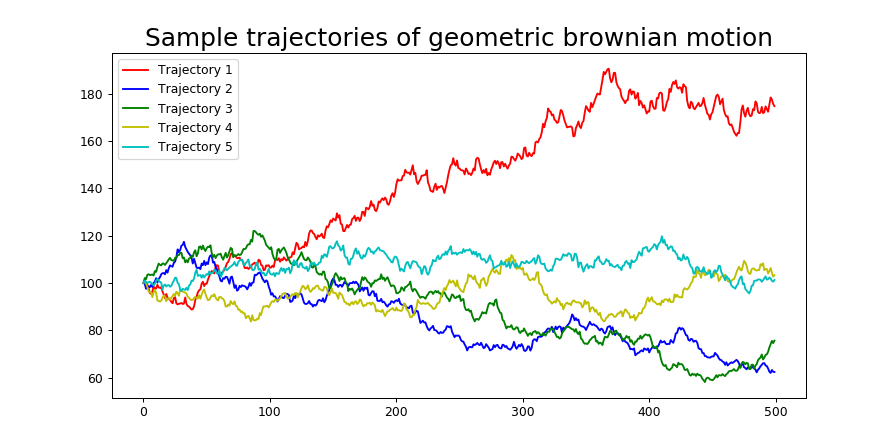

In [15]:
# plot the trajectories
colors = ['r', 'b', 'g', 'y', 'c']
fig_sample_traj = plt.figure(1)
ax_sample_traj = fig_sample_traj.add_subplot(111)
for k in range(5):
    ax_sample_traj.plot(trajs[k], color=colors[k], label="Trajectory " + str(k+1))
ax_sample_traj.set_title('Sample trajectories of geometric brownian motion', fontsize=20)
ax_sample_traj.legend(loc='upper left')


Before proceeding, it is worth recalling that the solution to the SDE above is:
$$ S(T) = S(0) \exp\left({(\mu - \frac{1}{2}\sigma^2)T + \sigma W(T)}\right) $$
With $S(0)$ being the starting price.

It follows that the distribution of the price $S(T)$ is lognormal. This can be easily verified formally. Here, we take an informal approach of simulating the trajectories and fitting the lognormal distribution to the final prices (prices that correspond to the latest time instance for a given trajectory).

In [8]:
N = 20000 # number of simulated tajectories
list_of_final_prices = []
# this might take a few seconds...
time_start = time.perf_counter()
for k in range(N):
    list_of_final_prices.append(sp.do_gbm_trajectory(x_0, n, d_t, mu, sigma)[-1])
time_end = time.perf_counter()
print("Time passed: ", str(time_end-time_start))

Time passed:  15.472460419000072


<IPython.core.display.Javascript object>


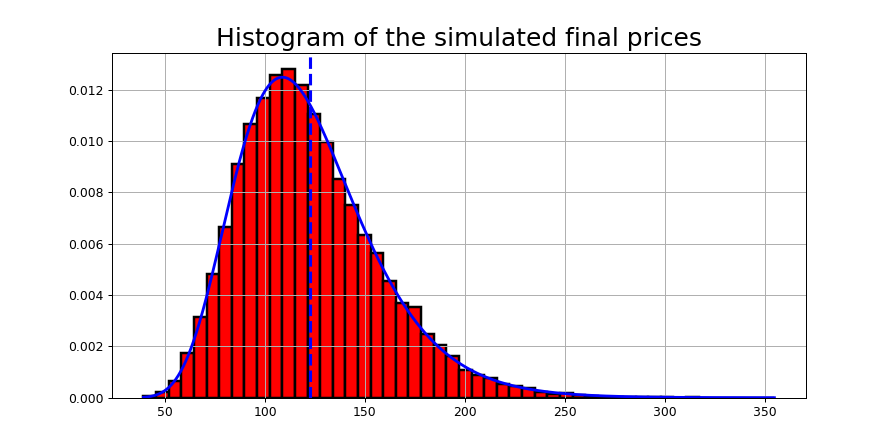

<class 'matplotlib.axes._subplots.AxesSubplot'>


In [23]:
# now, let's plot the histogram:
df_fin_prices = pd.DataFrame(data=list_of_final_prices, columns=['Values'])
fig_histogram = plt.figure(2)
prices_histogram = df_fin_prices.loc[:, 'Values'].hist(bins=50, color='r', normed=True, edgecolor='black', linewidth=2)
print(type(prices_histogram))
prices_histogram.set_title("Histogram of the simulated final prices", fontsize=20)
# add vertical line at the point of expectation
vline_loc = df_fin_prices.loc[:, 'Values'].mean()
prices_histogram.axvline(vline_loc, color='b', linestyle='dashed', linewidth=2.5)
# and add the fitted lognormal distribution curve:
lognorm_emp_mean = np.log(df_fin_prices.loc[:, 'Values']).mean()
lognorm_emp_std = np.log(df_fin_prices.loc[:, 'Values']).std()
lognorm_grid = np.linspace(df_fin_prices.loc[:, 'Values'].min(), df_fin_prices.loc[:, 'Values'].max(), 1000)
lognorm_pdf = spst.lognorm.pdf(lognorm_grid, s=lognorm_emp_std, scale=np.exp(lognorm_emp_mean))
prices_histogram.plot(lognorm_grid, lognorm_pdf, color='b', linewidth=2.25)

Checking only the distribution of the final price is not really that compelling. So let's have a look at the distribution of the maximum of the stock price over a fixed time interval $[0, T]$. 

We start by looking at the distribution of the maximum of a standard Wiener process, which is driving the changes of $S(t)$, over the period [0, t]:

$$ M(t) = \sup \left\{s \in [0,t]: W(s) \right\} $$


The random variable $M(t)$ is called $running$ $maximum$.

Using the reflection property of the Wiener process it can be demonstrated that $M(t)$ has the following c.d.f and p.d.f. under the real-world measure $\mathbb{P}$: 

$$ F_{M(t)}(m) = 2 \left( 1-P(W(t) \leq m) \right) = 2 \left( 1 - P \left( U \leq \frac{m}{\sqrt{t}} \right) \right)$$

$$ f_{M(t)}(m) = \frac{2}{\sqrt{2 \pi t}} e^{-m^2/(2t)} $$

Now, let's generate Wiener process trajectories and have the look at the empirical distribution of the maxima.

In [21]:
N = 50000 # number of trajectories
n = 500 # number of steps
d_t = 1/250 # time step length
list_of_maxima = []
time_start = time.perf_counter()
for k in range(N):
    # Wiener process always starts at (0,0)
    temp_traj = np.cumsum(np.hstack([np.zeros(1), np.random.normal(size=n, loc=0, scale=math.sqrt(d_t))]))
    list_of_maxima.append(temp_traj.max())
time_end = time.perf_counter()
print("Time elapsed: ", str(time_end - time_start))

Time elapsed:  2.25445462100015


<IPython.core.display.Javascript object>


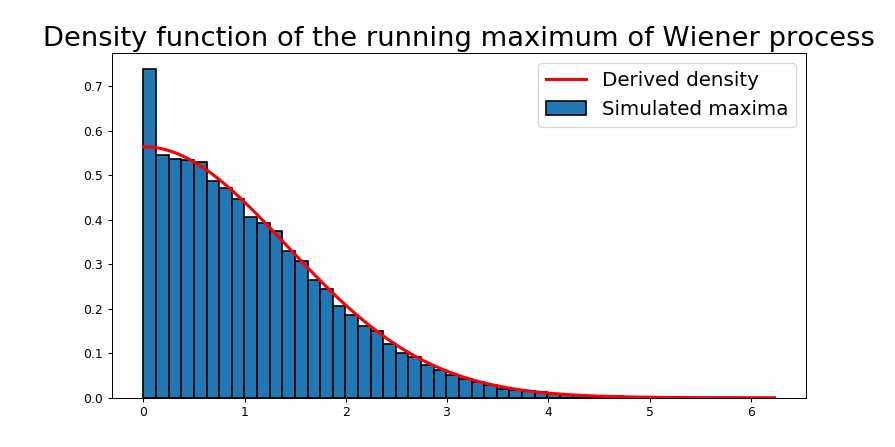

In [24]:
# plot the maxima
maxima_dist_fig = plt.figure(3)
maxima_dist_axes = maxima_dist_fig.add_subplot(111)
maxima_dist_axes.hist(list_of_maxima, bins = 50, normed=True, label="Simulated maxima", edgecolor='black', linewidth=1.33)
# now add the above-mentioned density on top of it
wiener_max_den_lambda = lambda m,t: 2/math.sqrt(2*math.pi*t)*np.exp(-m**2/(2*t))
temp_range = np.linspace(min(list_of_maxima), max(list_of_maxima), 1000)
max_dist_density = [wiener_max_den_lambda(m, 2) for m in temp_range]
maxima_dist_axes.plot(temp_range, max_dist_density, color='r', linewidth=2.5, label = 'Derived density')
maxima_dist_axes.legend(loc="upper right", fontsize=16)
maxima_dist_axes.set_title("Density function of the running maximum of Wiener process", fontsize=22)

Using the reflection property of the standard Wiener process it is also possible to prove that the joint probability density function of $(M(t), W(t))$ under the real-world measure $\mathbb{P}$ is:

$$ f_{M(t), W(t)}(m,w) = \frac{2(2m-w)}{t\sqrt{2 \pi t}} \exp \left\{ -\frac{1}{2} \frac{(2m-w)^2}{t} \right\} $$

on the region  $ S = \left\{ (m,w) \in \mathbb{R}^2: m \geq 0, m \geq w  \right\} $.

In [25]:
# function to calculate the probability density function of the joint distribution of (M(t), W(t))
def joint_density_max_and_wiener(m,w,t):
    if m < w:
        return 0
    elif m < 0:
        return 0
    else:
        const = ((2*(2*m-w))/(t*math.sqrt(t*math.pi*2)))
        val = const*np.exp(-(2*m-w)**2/(2*t))
    return val

In [28]:
# calculate the values of the p.d.f. of the joint distribution on a custom grid
t = 5 # fixing a time value
m_range = np.linspace(0,5,600)
w_range = np.linspace(-5,5,600)
M_rg, W_rg = np.meshgrid(m_range, w_range)

temp_args = list(zip(np.ravel(M_rg), np.ravel(W_rg)))
temp_vals = [joint_density_max_and_wiener(temp_arg[0], temp_arg[1],t) for temp_arg in temp_args]
temp_vals = np.array(temp_vals).reshape(M_rg.shape)

<IPython.core.display.Javascript object>


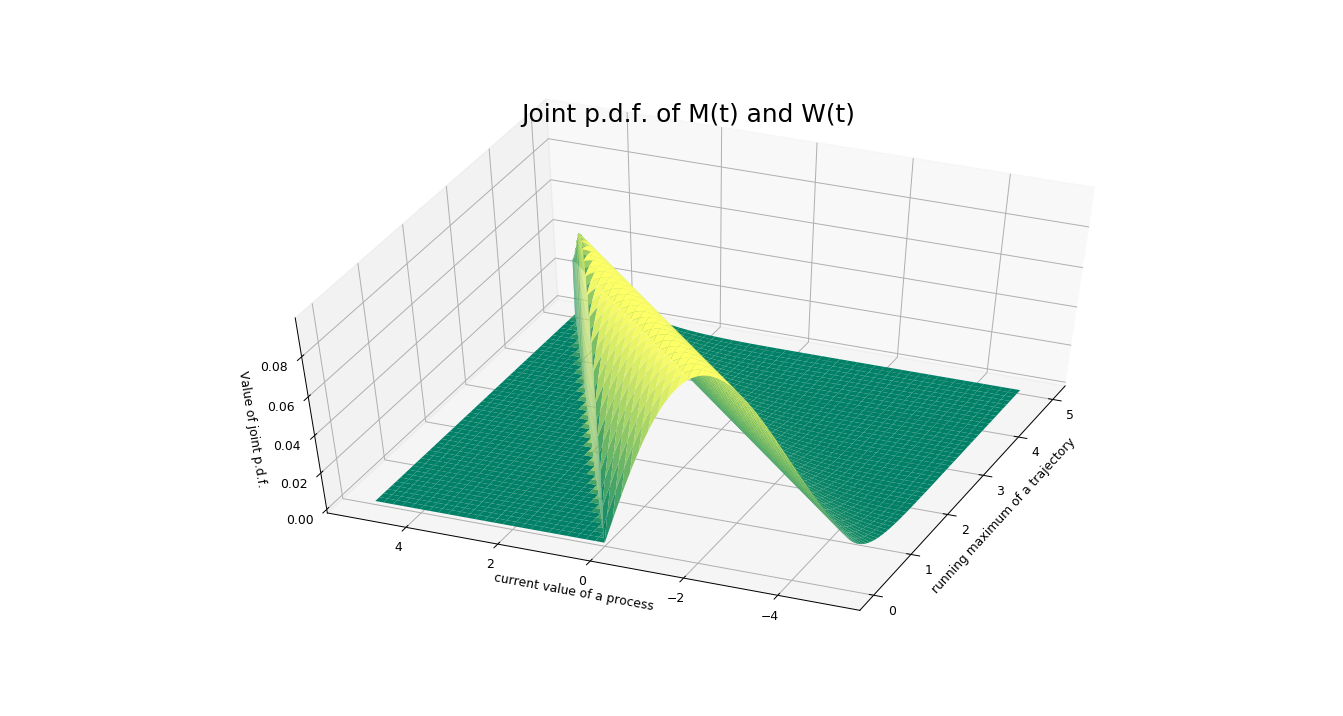

In [37]:
# Now, let's plot these values
plt.rcParams['figure.figsize'] = (15.0, 8.0)
joint_pdf_fig = plt.figure(4)
joint_pdf_axes = joint_pdf_fig.add_subplot(111, projection='3d')
joint_pdf_axes.plot_surface(M_rg, W_rg, temp_vals, cmap=cmp.summer)
# add axes titles
joint_pdf_axes.set_xlabel("running maximum of a trajectory")
joint_pdf_axes.set_ylabel("current value of a process")
joint_pdf_axes.set_zlabel("Value of joint p.d.f.")
joint_pdf_axes.set_title("Joint p.d.f. of M(t) and W(t)", fontsize=20)